In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import thinkbayes2
plt.style.use('ggplot')

In [2]:
WEIGHTS = {'A': .177,
           'B': .151,
           'C': .130,
           'D': .077}

DAYDIV = 167

In [3]:
class Electorate(thinkbayes2.Suite):
    '''Represents hypotheses about the state of the electorate'''
    
    def Likelihood(self, data, hypo):
        '''
        Likelihood of the data under the hypothesis.

        hypo: fraction of the population
        data: poll results
        '''
        bias, std, result = data
        error = result - hypo
        like = thinkbayes2.EvalNormalPdf(error, bias, std)
        return like

class PollAggregator:
    '''Estimator of the poll distributions'''
    
    
    def __init__(self, N=1000):
        self.suite = Electorate(np.linspace(0, 1, N))
        self.poll_vals = []
        self.poll_sizes = []
    
    
    def update(self, val, grade, nsamp, days):
        self.poll_vals.append(val)
        self.poll_sizes.append(nsamp)
        
        pvs = np.array(self.poll_vals)
        pss = np.array(self.poll_sizes)
        stdev_shift = np.mean(np.sqrt(pvs * (1 - pvs) / pss))
        
        stdev = np.sqrt(val * (1 - val) / nsamp) + 0.01 / WEIGHTS[grade] - stdev_shift
        
        data = 0, stdev, val
        self.suite.Update(data)
        
        
    def display(self):
        pmf = np.array(list(self.suite.Items()))
        plt.plot(pmf[:,0], pmf[:,1])
    
    def e_val(self):
        pmf = np.array(list(self.suite.Items()))
        return np.dot(pmf[:,0], pmf[:,1])

In [4]:
districts = list(pd.read_csv('districts.csv', header=None).iloc[:,0])
df = pd.read_excel('PoliStat polls (Responses).xlsx', sheet='Form Responses 1')

In [5]:
polls = {district: PollAggregator() for district in districts}

for index, row in df.iterrows():
    val = row['Democratic percent (Not margin, not 2-party)']
    grade = row['Pollster Grade https://projects.fivethirtyeight.com/pollster-ratings/ (Put D if N/A)']
    
    year = int(str(row['Final date taken']).split(' ')[0].split('-')[0])
    month = int(str(row['Final date taken']).split(' ')[0].split('-')[1])
    day = int(str(row['Final date taken']).split(' ')[0].split('-')[2])
    d0 = date(year, month, day)
    d1 = date(2018, 11, 6)
    days = d1 - d0
    days = days.days
    
    nw = np.exp(days / 30)
    nsamp = row['Sample Size']
    
    polls[row['District Name (e.g. AZ-03, WA-11)']].update(val, grade, nsamp, days)

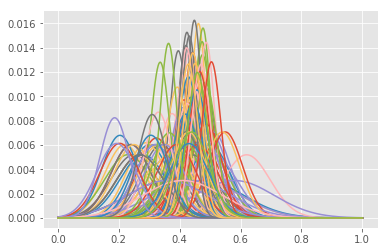

In [6]:
for poll in polls:
    if len(polls[poll].poll_vals) > 0:
        polls[poll].display()
#         plt.show()

In [7]:
with open('ppoll_n.csv', 'w') as f:
    for poll in polls:
        if len(polls[poll].poll_vals) > 0:
            f.write(poll + ',' + str((polls[poll].e_val() - 0.5) * 100) + '\n')
        else:
            f.write(poll + ',' + '0\n')
            
print('Done')

Done
